# Directory field

In [1]:
import nbimporter

import copy
import pickle

import smecticsFCD
#import smecticsViz

smecticsFCD.ipynb:430: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  "                    DSq[c1,c2] += D[c1,c3] * D[c3,c2]\n",


In [ ]:
#import matplotlib
#matplotlib.use('WebAgg')

In [ ]:
#import matplotlib.pyplot as plt 
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib

In [2]:
""" FIELD ATTRIBUTES """
N, Nz, L = 64, 32, 4.0
K, K24 = 0.04, -1.5*0.04
bcs = 'planar' # Strict anchoring
frequency = 0.0
alpha, beta, gamma, sq_root_core = 0.0, 0.0, 0.0, True
seed = 50

""" SIMULATION ATTRIBUTES """
stepper_dic={'GD': smecticsFCD.gradientDescentStepper, 'OSD': smecticsFCD.operatorSplittingDislocations,
        'OSG':smecticsFCD.operatorSplittingGap }
integrator_dic = {'simple_euler': 0, 'adaptive_euler': 1}
stepper = stepper_dic['GD']
integrator = integrator_dic['simple_euler']
load_file, load_state_file, load_time = False, './fileM2.pkl', 5000.0 # Use None for t_f 
time_step, final_time = 10e-5, 2
skip = 5
tolerance = 1E-6

"""SIMULATION"""
field = smecticsFCD.DirectorField( N=N, Nz=Nz, L=L, K=K, K24=K24,
        F=frequency, alpha=alpha, beta=beta, gamma=gamma, sqCore=sq_root_core,
        bcs=bcs, seed=seed )
if load_file:
    if load_time==None:
        smecticsFCD.loadFinalState( field, load_state_file )
    else:
        smecticsFCD.loadFieldAtT( field, load_time, load_state_file )
"""if integrator==0:
    smecticsFCD.simpleEulerIntegrator( field, time_step=time_step, save_skip=skip, end_time=final_time,
            stepper=stepper, verbose=True )
elif integrator==1:
    smecticsFCD.adaptiveEulerIntegrator( field, initial_step_size=1e-6, time_step=time_step,
            approximate_end_time=final_time, atol=tolerance, stepper=stepper, verbose=True )"""
"""Chose atol ~ of error... when using acceptReject stable..."""

'Chose atol ~ of error... when using acceptReject stable...'

In [3]:
smecticsFCD.simpleEulerIntegrator( field, time_step=time_step, save_skip=skip, end_time=final_time,
            stepper=stepper, verbose=True )

Running simulation...
It took this routine 107.13316139666667 min.


### Plot of director field 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

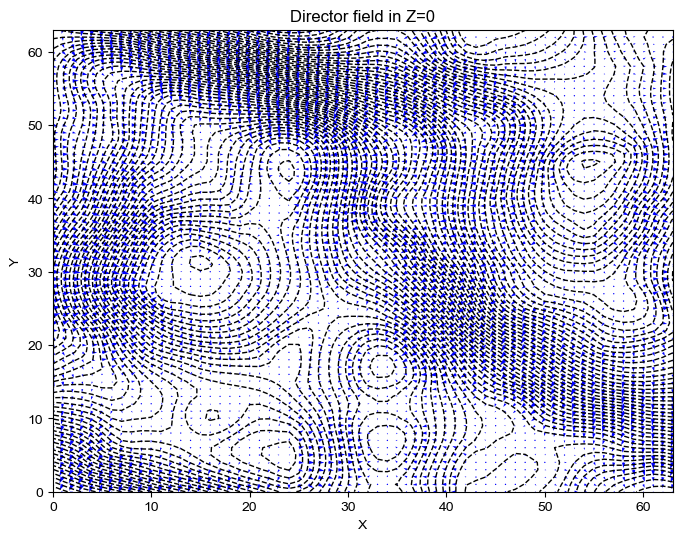

In [5]:
layers = field.massDensity()
layers2D = layers[...,0]
layer_contours = np.linspace( layers2D.min(), layers2D.max(), N ).tolist()

r = field.rspace()
X2D = r['x'][...,0]
Y2D = r['y'][...,0]
nx2D = field.field['x'][...,0]
ny2D = field.field['y'][...,0]

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")

ax.quiver(X2D, Y2D, nx2D, ny2D, color='b')#, angles='xy', scale_units='xy', scale=0.7)
ax.contour( layers2D.T, levels=layer_contours, colors='k', linewidths=1 )

ax.set_title("Director field in Z=0")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

In [7]:
#smecticsViz.layers2D(field, section=('z', 0), layers_field=[], layer_contours=[], show_f=True, range=[])

# Swimmer's equation of motion in 2D

In [8]:
def velocity(speed):
    #N, Nz = 32, 32
    v = {
        'x': np.full((1), speed), #np.full((N, N, Nz), speed)
        'y': np.full((1), speed),
        'z': np.full((1), speed)} 
    return v
def st(noise_strength):
    #N, Nz = 32, 32
    st = {
        'x': noise_strength*np.random.normal(0, 1, 1), #np.random.normal(0, 1, (N,N,Nz))
        'y': noise_strength*np.random.normal(0, 1, 1),
        'z': noise_strength*np.random.normal(0, 1, 1)} 
    return st

In [9]:
from itertools import product
def kvvndn(r, v, k, N):
    """This is a function that returns the second term in the discretized equation."""
    #N=32
    components = ['x','y','z']
    v_normalized = smecticsFCD.unitField(v)
    n_normalized = smecticsFCD.unitField(field.field)
    idx, idy, idz = np.round(r).astype(int) % N
    n_gradient_tensor = field.gradientTensor()
    first_term = {c1: 0 for c1 in components}
    for c1, c2, c3 in product(components, repeat=3):
        first_term[c1] += k*v_normalized[c2]*v_normalized[c3]*n_normalized[c2][idx, idy, idz]*n_gradient_tensor[c1,c3][idx, idy, idz]
    return first_term

In [10]:
def next_position(dimension , r, v, Delta_t, num_steps, k, noise_strength, N):
    """This function returns the evolution of the particle within 
    the smectic's directory field and depends on the dimension you 
    are interested in. """
    #N = 32
    if dimension == str('2D'):
        components = ['x', 'y']
        r[-1] = 0
    if dimension == str('3D'):
        components = ['x', 'y', 'z']
    trajectory = [r.copy()]
    #velocity2 = v_t.copy()
    for step in range(num_steps):
        noise = st(noise_strength)
        v = v.copy()
        deterministic_term = kvvndn(r, v, k, N)
        for i, c in enumerate(components):
            r[i] += deterministic_term[c].item() * Delta_t + noise[c].item() * Delta_t 
            r[i] = np.mod(r[i], N)
            v[c] = deterministic_term[c] + noise[c]
        trajectory.append(r.copy())
        #velocity2[c].append(v_t[c].item().copy())
    if dimension == str('2D'):
        return np.delete(trajectory, 2, axis=1)
    if dimension == str('3D'):
        return np.array(trajectory)#, velocity2

In [46]:
r = np.array([32.4, 30.8, 29.5])
v = velocity(3.0)
k = 2
noise_strength = 0.25
trajectory2D = next_position('2D',r,v,1,2000, k, noise_strength, N)
#trajectory3D = next_position('3D',r,v,1,200)

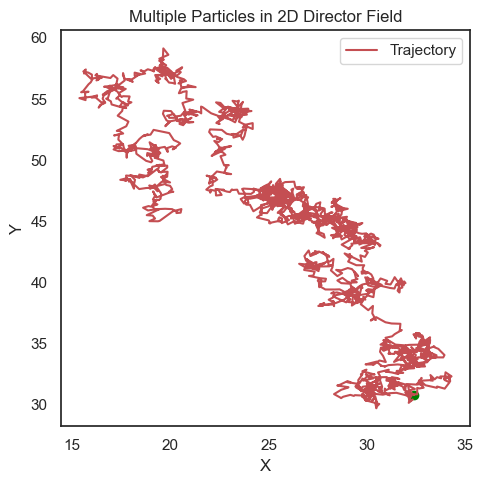

In [47]:
plt.figure(figsize=(5, 5))
sns.set(style="white")

plt.plot(trajectory2D[:, 0], trajectory2D[:, 1], label="Trajectory", color='r')
plt.scatter(trajectory2D[0, 0], trajectory2D[0, 1], color='green')

plt.title("Multiple Particles in 2D Director Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.tight_layout()
plt.show()

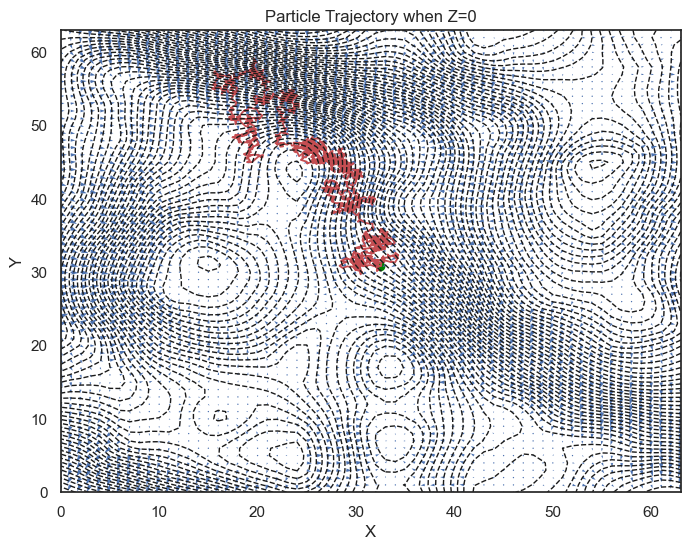

In [48]:
layers = field.massDensity()
layers2D = layers[...,0]
layer_contours = np.linspace( layers2D.min(), layers2D.max(), N ).tolist()

r = field.rspace()
X2D = r['x'][...,0]
Y2D = r['y'][...,0]
nx2D = field.field['x'][...,0]
ny2D = field.field['y'][...,0]

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")

ax.plot(trajectory2D[:, 0], trajectory2D[:, 1], label="Trajectory", color='r', linewidth=1.3)
ax.scatter(trajectory2D[0, 0], trajectory2D[0, 1], color='green', label="Start")

ax.quiver(X2D, Y2D, nx2D, ny2D, color='b')#, angles='xy', scale_units='xy', scale=0.7)
ax.contour( layers2D.T, levels=layer_contours, colors='k', linewidths=1 )

ax.set_title("Particle Trajectory when Z=0")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

In [49]:
def unwrap_trajectory(trajectory, N):
    unwrapped = trajectory.copy()
    for i in range(1, len(trajectory)):
        delta = trajectory[i] - trajectory[i - 1]
        delta = delta - N * np.round(delta / N)  # minimum image convention
        unwrapped[i] = unwrapped[i - 1] + delta
    return unwrapped

In [50]:
unwrapped_traj = unwrap_trajectory(trajectory2D, N)

In [51]:
def compute_MSD(trajectory):
    N = len(trajectory)
    msd = np.zeros(N)

    for tau in range(N):
        displacements = trajectory[tau:, :2] - trajectory[:N - tau, :2]  # Solo X e Y
        squared_displacements = np.sum(displacements**2, axis=1)
        msd[tau] = np.mean(squared_displacements)

    return msd

In [52]:
msd_values = compute_MSD(unwrapped_traj)

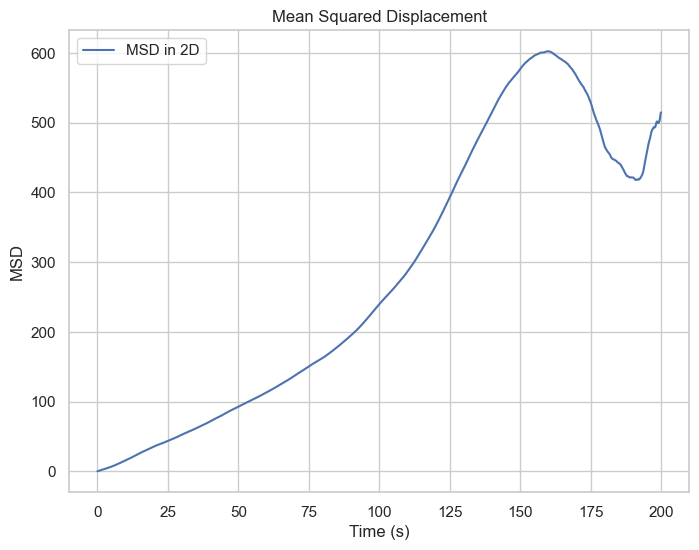

In [53]:
time_lags = np.arange(len(msd_values)) * 0.1

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.lineplot(x=time_lags, y=msd_values, label="MSD in 2D", color="b")

plt.xlabel("Time (s)")
plt.ylabel("MSD")
plt.title("Mean Squared Displacement")
plt.legend()
plt.show()

In [ ]:
import matplotlib.colors as mcolors
def colors_hsv(num_particles, saturation=0.7, brightness=0.9):
    step = 1.7 / num_particles
    colors = []
    for i in range(num_particles):
        matriz = i * step
        rgb = mcolors.hsv_to_rgb((matriz, saturation, brightness))
        colors.append(mcolors.to_hex(rgb))
    return colors

### Many Particles with initial random position 

In [21]:
def many_particles(num_particles, Delta_t, num_steps, k, noise_strength, N):
    #N = 32
   
    positions = np.random.uniform(0, N, (num_particles, 3))
    v_0 = velocity(3.0) 
    trajectories = [ [] for i in range(num_particles) ]
    
    for i in range(num_particles):
        r = next_position('2D', positions[i], v_0,Delta_t, num_steps, k, noise_strength, N)
        trajectories[i].append(r.copy())
    return trajectories

In [55]:
k = 2
Delta_t = 1
num_steps = 1000
noise_strength = 0.4
num_particles = 5
trajectories2D = [np.array(traj) for traj in many_particles(num_particles, Delta_t, num_steps, k, noise_strength, N)]

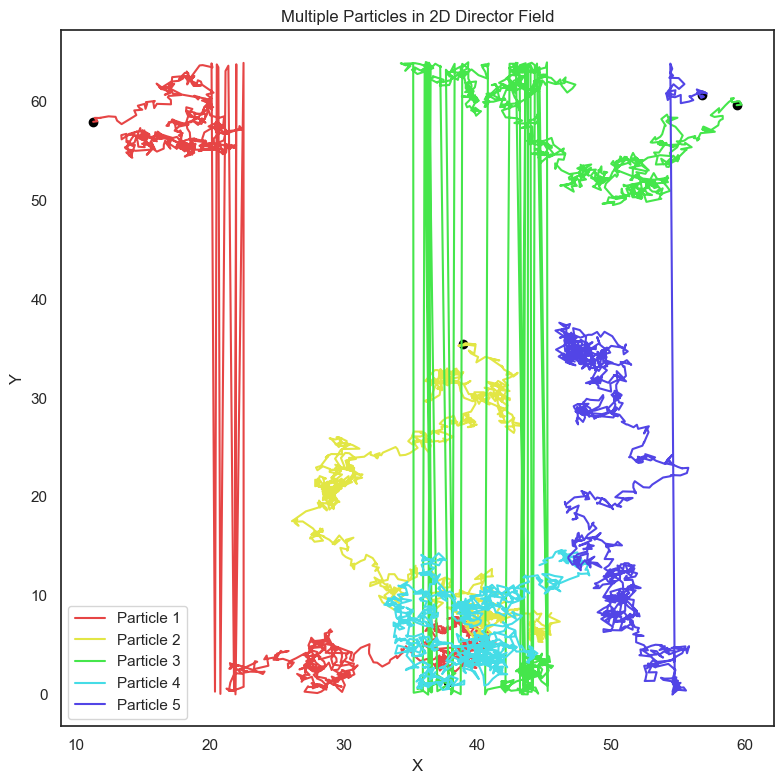

In [57]:
plt.figure(figsize=(8, 8))
sns.set(style="white")

colors = colors_hsv(10)
for i in range(num_particles):
    plt.plot(trajectories2D[i][0][:, 0], trajectories2D[i][0][:, 1], color=colors[i % len(colors)], label=f'Particle {i+1}')
    plt.scatter(trajectories2D[i][0][0, 0], trajectories2D[i][0][0, 1], color='black')
    
plt.title("Multiple Particles in 2D Director Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.tight_layout()
plt.show()

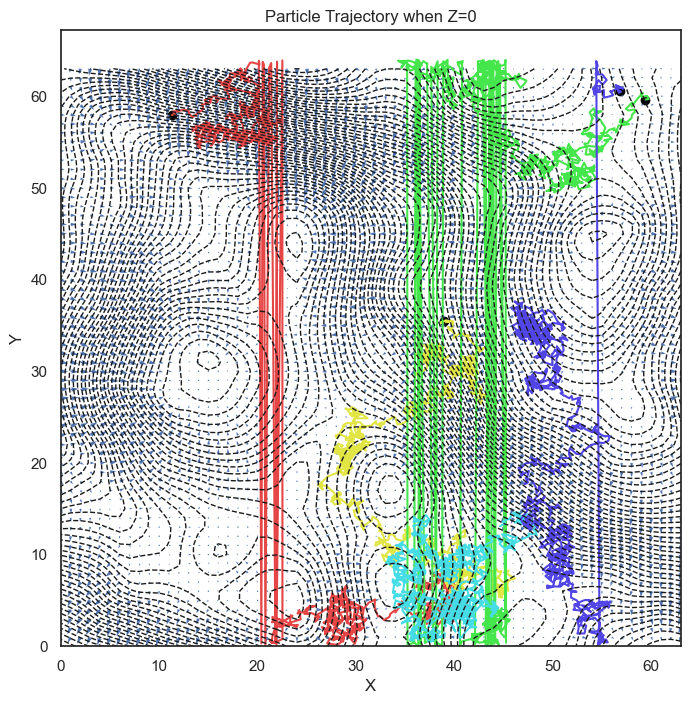

In [58]:
layers = field.massDensity()
layers2D = layers[...,0]
layer_contours = np.linspace( layers2D.min(), layers2D.max(), N ).tolist()

r = field.rspace()
X2D = r['x'][...,0]
Y2D = r['y'][...,0]
nx2D = field.field['x'][...,0]
ny2D = field.field['y'][...,0]

fig, ax = plt.subplots(figsize=(8, 8))
sns.set(style="white")

colors = colors_hsv(10)
for i in range(num_particles):
    ax.plot(trajectories2D[i][0][:, 0], trajectories2D[i][0][:, 1], color=colors[i % len(colors)], label=f'Particle {i+1}')
    ax.scatter(trajectories2D[i][0][0, 0], trajectories2D[i][0][0, 1], color='black', label="Start")

ax.quiver(X2D, Y2D, nx2D, ny2D, color='b')#, angles='xy', scale_units='xy', scale=0.7)
ax.contour( layers2D.T, levels=layer_contours, colors='k', linewidths=1 )

ax.set_title("Particle Trajectory when Z=0")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

In [59]:
def process_all_particles(trajectories, N):
    msds = []
    for i, traj in enumerate(trajectories):
        traj2D = traj[0]
        unwrapped = unwrap_trajectory(traj2D, N)
        msd = compute_MSD(unwrapped)
        msds.append(msd)
    return msds

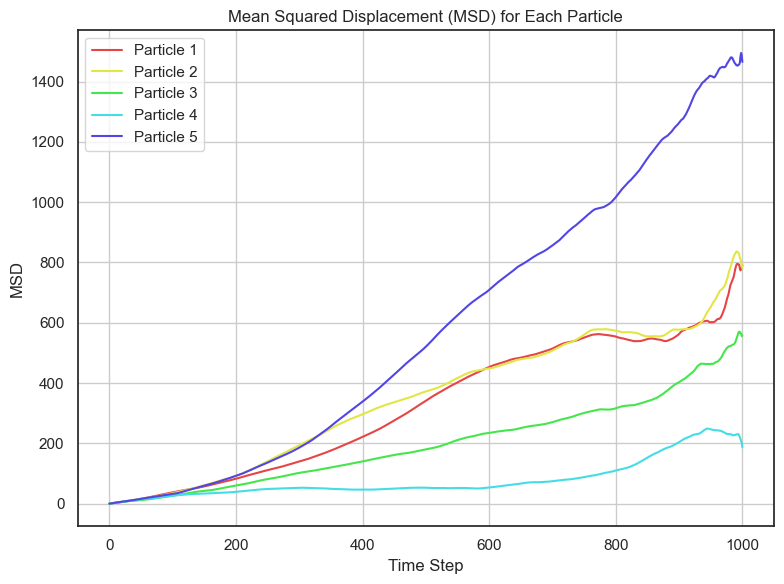

In [60]:
msds = process_all_particles(trajectories2D, N)

# Plot
plt.figure(figsize=(8, 6))

colors = colors_hsv(10)
for i, msd in enumerate(msds):
    plt.plot(msd, color=colors[i % len(colors)], label=f'Particle {i+1}')
plt.xlabel('Time Step')
plt.ylabel('MSD')
plt.title('Mean Squared Displacement (MSD) for Each Particle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Many Particles with initial position beween 28 to 40 on the grid

In [ ]:
def many_particles_same(num_particles, Delta_t, num_steps, k, noise_strength, N):
    #N = 32
   
    positions = np.random.uniform(low=28, high=40, size=(num_particles, 3))
    v_0 = velocity(3.0) 
    trajectories = [ [] for i in range(num_particles) ]
    
    for i in range(num_particles):
        r = next_position('2D', positions[i], v_0,Delta_t, num_steps, k, noise_strength, N)
        trajectories[i].append(r.copy())
    return trajectories

In [56]:
k = 2
Delta_t = 1
num_steps = 1000
noise_strength = 0.4
num_particles = 5
trajectories2D_same = [np.array(traj) for traj in many_particles_same(num_particles, Delta_t, num_steps, k, noise_strength, N)]

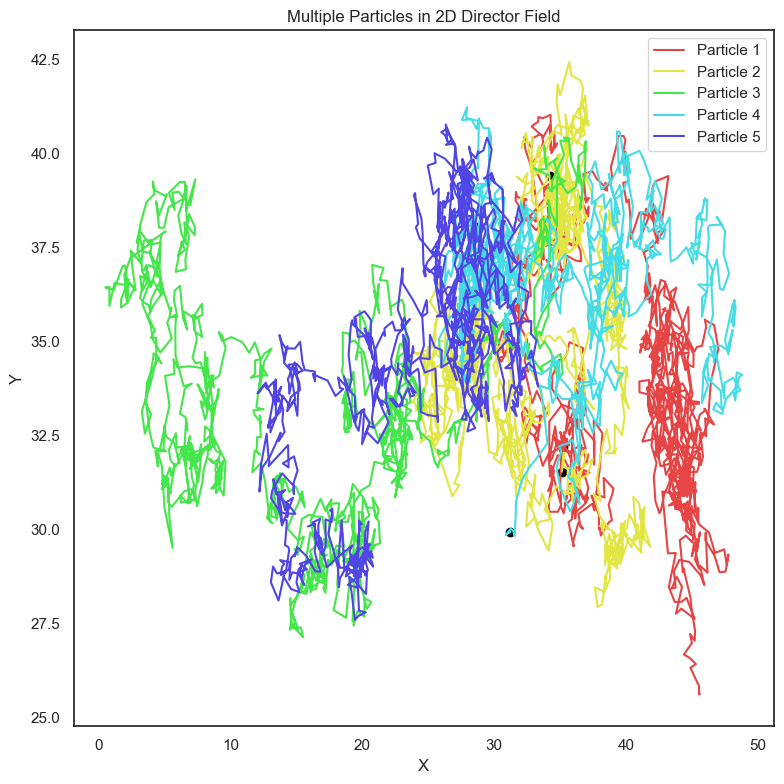

In [61]:
plt.figure(figsize=(8, 8))
sns.set(style="white")

colors = colors_hsv(10)
for i in range(num_particles):
    plt.plot(trajectories2D_same[i][0][:, 0], trajectories2D_same[i][0][:, 1], color=colors[i % len(colors)], label=f'Particle {i+1}')
    plt.scatter(trajectories2D_same[i][0][0, 0], trajectories2D_same[i][0][0, 1], color='black')
    
plt.title("Multiple Particles in 2D Director Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.tight_layout()
plt.show()

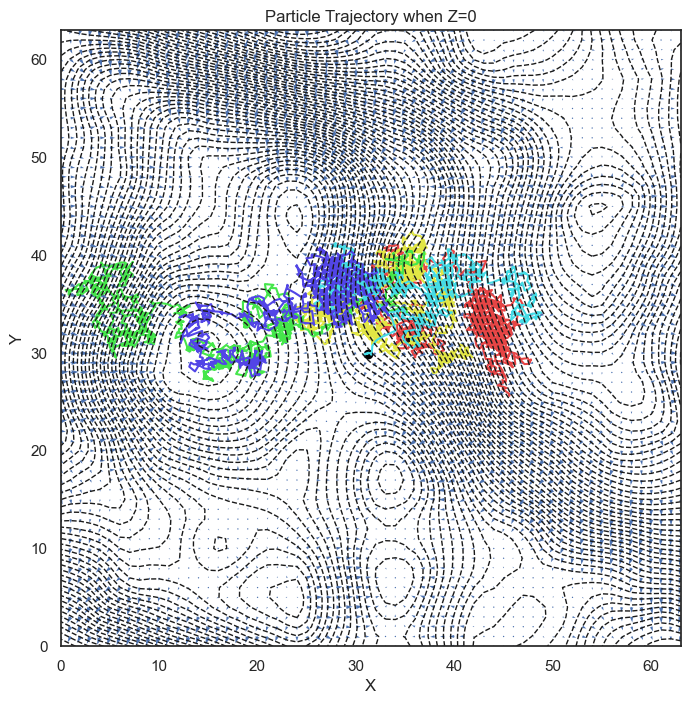

In [62]:
layers = field.massDensity()
layers2D = layers[...,0]
layer_contours = np.linspace( layers2D.min(), layers2D.max(), N ).tolist()

r = field.rspace()
X2D = r['x'][...,0]
Y2D = r['y'][...,0]
nx2D = field.field['x'][...,0]
ny2D = field.field['y'][...,0]

fig, ax = plt.subplots(figsize=(8, 8))
sns.set(style="white")

colors = colors_hsv(10)
for i in range(num_particles):
    ax.plot(trajectories2D_same[i][0][:, 0], trajectories2D_same[i][0][:, 1], color=colors[i % len(colors)], label=f'Particle {i+1}')
    ax.scatter(trajectories2D_same[i][0][0, 0], trajectories2D_same[i][0][0, 1], color='black', label="Start")

ax.quiver(X2D, Y2D, nx2D, ny2D, color='b')#, angles='xy', scale_units='xy', scale=0.7)
ax.contour( layers2D.T, levels=layer_contours, colors='k', linewidths=1 )

ax.set_title("Particle Trajectory when Z=0")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

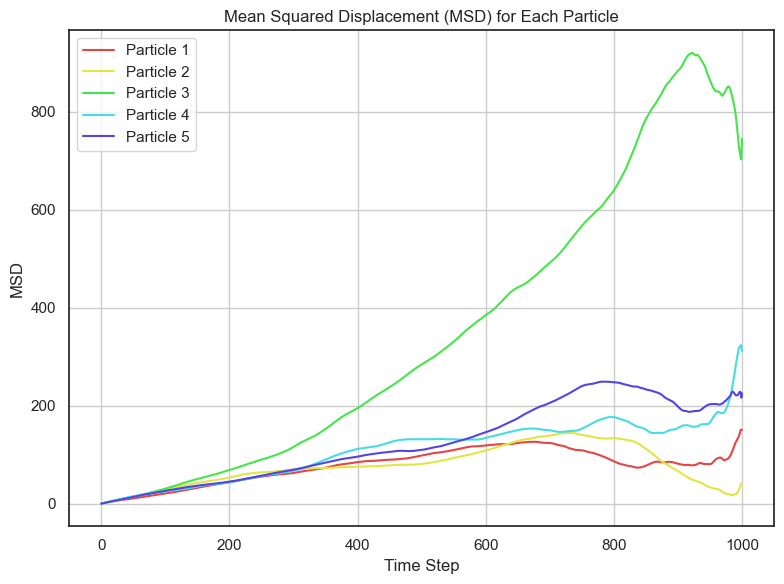

In [63]:
msds_same = process_all_particles(trajectories2D_same, N)

# Plot
plt.figure(figsize=(8, 6))

colors = colors_hsv(10)
for i, msd in enumerate(msds_same):
    plt.plot(msd, color=colors[i % len(colors)], label=f'Particle {i+1}')
plt.xlabel('Time Step')
plt.ylabel('MSD')
plt.title('Mean Squared Displacement (MSD) for Each Particle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Swimmer's equation of motion

\begin{equation}
\dot{\vec{r}} =-\vec{\nabla } E+\vec{\zeta }
\end{equation}

where

\begin{aligned}
E & =-\frac{k}{2}(\hat{v} \cdotp \hat{n}(\vec{r}))^{2}\\
E & =-\frac{k}{2}( v_{i} n_{i})( v_{j} n_{j})
\end{aligned}

So: 

\begin{aligned}
\dot{\vec{r}} & =\frac{k}{2}\vec{\nabla }( v_{i} n_{i})( v_{j} n_{j}) +\vec{\zeta }\\
\dot{\vec{r}} & =\frac{k}{2}[ v_{i} n_{i}\vec{\nabla }( v_{j} n_{j}) +v_{j} n_{j}\vec{\nabla }( v_{i} n_{i})] +\vec{\zeta }\\
\dot{\vec{r}} & =kv_{i} v_{j} n_{i}\vec{\nabla } n_{j} +\vec{\zeta }\\
\dot{\vec{r}} & =kv_{i} v_{j} n_{i}\hat{e}_{k} \partial _{k} n_{j} +\vec{\zeta }
\end{aligned}

The discretized equation of motion for the swimmer:

\begin{aligned}
\vec{r}( t+\Delta t) & =\vec{r}(t)+k\Delta tv_{i}( t) v_{j}( t) n_{i}\vec{\nabla } n_{j} +\Delta t\vec{\zeta }\\
 & \\
r_{k}( t+\Delta t) & =r_{k}(t)+k\Delta tv_{i}( t) v_{j}( t) n_{i} \partial _{k} n_{j} +\Delta t\zeta _{k}
\end{aligned}

### Normalizing the directory field

### Calculating the gradient of the field (tensor)

$$\vec{\nabla } n_{j}\ \ or \ \ \partial_k n_j$$

### Creating a dictionary for velocity and generating a random distribution

In [ ]:
def velocity(speed):
    #N, Nz = 32, 32
    v = {
        'x': np.full((1), speed), #np.full((N, N, Nz), speed)
        'y': np.full((1), speed),
        'z': np.full((1), speed)} 
    return v
def st():
    #N, Nz = 32, 32
    st = {
        'x': np.random.normal(0, 1, 1), #np.random.normal(0, 1, (N,N,Nz))
        'y': np.random.normal(0, 1, 1),
        'z': np.random.normal(0, 1, 1)} 
    return st

### Let's calculate the second term of the swimmer's motion equation:

$$kv_{i}( t) v_{j}( t) n_{i}\vec{\nabla } n_{j}=k\sum_{j=1}^3\left[\sum_{i=1}^3v_{i}( t) v_{j}( t) n_{i}\vec{\nabla } n_{j}\right]$$

In [ ]:
from itertools import product
def kvvndn(r, v, k):
    components = ['x','y','z']
    v_normalized = smecticsFCD.unitField(v)
    n_normalized = smecticsFCD.unitField(field.field)
    idx = np.round(r).astype(int)
    n_gradient_tensor = field.gradientTensor()
    first_term = {c1: 0 for c1 in components}
    for c1, c2, c3 in product(components, repeat=3):
        first_term[c1] += k*v_normalized[c2]*v_normalized[c3]*n_normalized[c2][*idx]*n_gradient_tensor[c1,c3][*idx]
    return first_term

### Now we evolve the swimmer's motion equation

$$r_{k}( t+\Delta t) =r_{k}(t)+k\Delta t\sum_{j=1}^3\left[\sum_{i=1}^3v_{i}( t) v_{j}( t) n_{i}\partial_k n_{j}\right] +\Delta t\zeta _{k}$$

In [ ]:
def next_position(r_t, v_t, Delta_t, num_steps):
    components = ['x', 'y', 'z']
    trajectory = [r_t.copy()]
    #velocity2 = v_t.copy()
    for step in range(num_steps):
        noise = st()
        velocity1 = v_t.copy()
        second_term = kvvndn(r_t, velocity1, 1)
        for i, c in enumerate(components):
            r_t[i] += second_term[c].item() * Delta_t + Delta_t * noise[c].item()
            v_t[c] = second_term[c] + noise[c]
        trajectory.append(r_t.copy())
        #velocity2[c].append(v_t[c].item().copy())
    return np.array(trajectory)#, velocity2

### Initial position of the particle and velocity

### Output of trajectory and speed data

In [ ]:
r_t = np.array([15.4, 13.8, 14.5])
v_t = velocity(2.0)
trajectory = next_position(r_t,v_t,0.1,200)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Trajectory', color = 'r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [ ]:
def compute_MSD(trajectory):
    N = len(trajectory)
    msd = np.zeros(N)

    for tau in range(N):
        displacements = trajectory[tau:] - trajectory[:N - tau]
        squared_displacements = np.sum(displacements**2, axis=1)
        msd[tau] = np.mean(squared_displacements)

    return msd

In [ ]:
msd_values = compute_MSD(trajectory)
#msd_values

In [ ]:
time_lags = np.arange(len(msd_values)) * 0.1  # Multiplicar por 0.1 si el intervalo es 0.1 s
plt.plot(time_lags, msd_values, label="MSD in 3D")
plt.xlabel("Tiem (s)")
plt.ylabel("MSD")
plt.title("Mean Squared Displacement")
plt.legend()
plt.show()

### Visualization

In [ ]:
smecticsViz.crossedPolarizers(field, z_section=0, scattering_amplitude=[], focus=True, show_f=True,
            amplitude=True, range=[], axes=False )